**Выпускной проект Яндекс.Практикума. A/B-тестирование**

**Курс: Аналитик данных**

---



**СОДЕРЖАНИЕ**

---
[**Описание проекта**](#description)

[**Импорт библиотек и загрузка данных**](#loading)

[**Предобработка данных**](#preparing)

[**Исследовательский анализ данных (EDA)**](#EDA)

[**Определение эффекта теста**](#effect)

[**Оценка результатов теста**](#statistics)

[**Выводы и рекомендации**](#summary)

---




## **Описание проекта**<a  class="anchor" id="description"></a>

##  **Импорт библиотек и загрузка данных**<a  class="anchor" id="loading"></a>

In [1]:
import pandas as pd
import datetime as dt

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns; sns.set(style='white')

import numpy as np
from scipy import stats as st
from statsmodels.stats.proportion import proportions_ztest

from plotly import graph_objects as go

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Функция для загрузки файлов с гугл-диска
def gdisk_gownload(link):
    url='https://drive.google.com/uc?id=' + link.split('/')[-2]
    return pd.read_csv(url)

In [3]:
# Загрузка данных
try:
    marketing_events=pd.DataFrame(pd.read_csv(' '))
    new_users=pd.DataFrame(pd.read_csv(' '))
    events=pd.DataFrame(pd.read_csv(' '))
    participants=pd.DataFrame(pd.read_csv(' '))
except:
    marketing_events=gdisk_gownload(' ')
    new_users=gdisk_gownload(' ')
    events=gdisk_gownload(' ')
    participants=gdisk_gownload(' ')

## **Предобработка данных**<a  class="anchor" id="preparing"></a>

### **Проверка типов данных, пропусков и дубликатов.**

Проверим датасеты на соотвествие типов данных описанию, отсутствие пропусков и дубликатов в категориях.

In [4]:
def check_dataset(dataset):
    """
    Функция для вывода информации о структуре и типах данных датафрейма, проверки на пропуски в столбцах и дубликаты записей
    Принимает на вход датафрейм
    Выводит информацию о:
    типах данных, наименовании столбцов и количестве записей в датафрейме;
    наличии пропусков в данных и их долей по столбцам;
    наличии и количестве дубликатов записей;
    десять случайных записей из датафрейма
    """
    
    try:
        name =[x for x in globals() if globals()[x] is dataset][0]
        width = 10*len(dataset.columns)
        print('\033[1m','Проверка таблицы: {}'.format(name),'\033[0m')
        print('.'*width)
        print('\033[1m','\nИнформация о типах данных:', '\033[0m')
        display(dataset.info())
        print('.'*width)
        if dataset.isna().mean().sum()==0:
            print('\033[1m', '\nПропусков в столбцах \033[32;1m НЕТ', '\033[0m')
        else:
            print('\033[1m', '\nДоля пропусков в столбцах:', '\033[0m')
            display(pd.DataFrame(round((dataset.isna().mean()*100),2)).style.background_gradient())
        print('.'*width)
        if dataset.duplicated().sum()==0:
            print('\033[1m', '\nДубликатов строк \033[32;1m НЕТ', '\033[0m')
        else:
            print('\033[1m', '\nКоличество дубликатов: \033[31;1m{}\033[0m'.format(dataset.duplicated().sum()))
        print('.'*width)
        print('\033[1m', '\n10 случайных строк датафрейма', '\033[0m')
        display(dataset.sample(10))
           
    except:
        print('Ошибка')



---

Проверим датасет, содержащий календарь маркетинговых событий на 2020 год.

In [5]:
check_dataset(marketing_events)

 Проверка таблицы: marketing_events 
........................................
 
Информация о типах данных: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


None

........................................
 
Пропусков в столбцах  НЕТ 
........................................
 
Дубликатов строк  НЕТ 
........................................
 
10 случайных строк датафрейма 


,name,regions,start_dt,finish_dt
11,Dragon Boat Festival Giveaway,APAC,2020-06-25,2020-07-01
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
13,Chinese Moon Festival,APAC,2020-10-01,2020-10-07


Датасет содержит 14 полных уникальных записи. Типы данных столбцов, содержащих даты не оптимальны.

Произведем преобразовния типов данных столбцов "start_dt" и "finish_dt" к типу datetime.

In [6]:
marketing_events['start_dt']=pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt']=pd.to_datetime(marketing_events['finish_dt'])



---

Проверим датасет, содержащий информацию о пользователях, зарегистрировавшихся с 7 по 21 декабря 2020 года.

In [7]:
check_dataset(new_users)

 Проверка таблицы: new_users 
........................................
 
Информация о типах данных: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


None

........................................
 
Пропусков в столбцах  НЕТ 
........................................
 
Дубликатов строк  НЕТ 
........................................
 
10 случайных строк датафрейма 


,user_id,first_date,region,device
12367,D6E7860CA644FCE4,2020-12-21,EU,Android
10222,7E7C5DED2420D2ED,2020-12-14,EU,Android
10989,6FCDE79ECCD897C2,2020-12-14,EU,PC
30460,36F2A33CA87C3D15,2020-12-16,EU,PC
57529,331C5FAD767FAA74,2020-12-20,EU,Android
50657,FE82F68B57E5BD1A,2020-12-19,N.America,Android
31747,DF60E6D6D77FDE1A,2020-12-23,N.America,iPhone
14975,2D9D64CC232179B8,2020-12-21,N.America,Android
28692,43C2CB237D7E60A9,2020-12-09,EU,Android
10693,E2242001C7022C33,2020-12-14,EU,Mac


Датасет содержит 61733  полных уникальных записи. Тип данных столбца, содержащего дату регистрации не оптимален.

Произведем преобразовния типа данных столбца "first_date" к типу datetime.

In [8]:
new_users['first_date']=pd.to_datetime(new_users['first_date'])



---

Проверим датасет, содержащий информацию о действиях новых пользователей в период с 7 по 4 января 2021 года.

In [9]:
check_dataset(events)

 Проверка таблицы: events 
........................................
 
Информация о типах данных: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


None

........................................
 
Доля пропусков в столбцах: 


,0
user_id,0.000000
event_dt,0.000000
event_name,0.000000
details,85.750000


........................................
 
Дубликатов строк  НЕТ 
........................................
 
10 случайных строк датафрейма 


,user_id,event_dt,event_name,details
282858,CCC6860A75C712F7,2020-12-12 12:45:32,login,NaN
95987,A50614A74A8993E1,2020-12-19 21:27:57,product_cart,NaN
207489,ABCFD2B2C9D667C0,2020-12-21 09:20:36,product_page,NaN
227633,C890B90703F73F15,2020-12-24 23:29:32,product_page,NaN
257775,F6D43F19A544F9C8,2020-12-08 20:10:52,login,NaN
401637,FAB608E544C82865,2020-12-23 22:18:39,login,NaN
253575,E2F6438B7AC758C5,2020-12-07 13:19:26,login,NaN
343036,86ECC21BC4259A63,2020-12-18 00:15:57,login,NaN
209424,F47AD83C17D8A4C3,2020-12-21 07:40:36,product_page,NaN
1841,9FF282CF749FC6BF,2020-12-08 19:39:35,purchase,4.99


Датасет содержит 440317 уникальных записей. Тип данных столбца, содержащего дату события не оптимален. У 87,75% записей есть пропущенные значения в столбце "Дополнительные данные о событии". 

Произведем преобразовния типа данных столбца "event_dt" к типу datetime.

In [10]:
events['event_dt']=pd.to_datetime(events['event_dt'])

Сгруппируем записи по типу события и проверим для каких событий пропущена детализирующая информация.

In [11]:
events.groupby('event_name')['details'].agg('count')

event_name
login               0
product_cart        0
product_page        0
purchase        62740
Name: details, dtype: int64

Детальная информация заполнена только для события "purchase" (данные о стоимости попупки). Произведем заполнение пропусков по полю "details" маркером отсутствующего значения.

In [12]:
events['details'].fillna(int(-1), inplace=True)



---

Проверим датасет, содержащий таблицу участников теста.

In [13]:
check_dataset(participants)

 Проверка таблицы: participants 
..............................
 
Информация о типах данных: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


None

..............................
 
Пропусков в столбцах  НЕТ 
..............................
 
Дубликатов строк  НЕТ 
..............................
 
10 случайных строк датафрейма 


,user_id,group,ab_test
10654,6A4A15D3C4754FF9,A,interface_eu_test
17213,F97D8746923ABA37,B,interface_eu_test
3726,F54F7DE3DCCD3BE6,B,recommender_system_test
8910,9B802A12D586586F,A,interface_eu_test
4219,EB1AC80421152AF3,B,recommender_system_test
10134,75A8B506065565B4,A,interface_eu_test
1981,AF098E00AB18A70B,B,recommender_system_test
853,1E32BD9626026E05,A,recommender_system_test
11564,2CEA7B33FA38B86B,B,interface_eu_test
6935,F905242F7F12A971,B,interface_eu_test


Датасет содержит 18268 полных уникальных записи. Тип данных столбцов соотвествуют описанию.

### **Актуализация датафреймов техническому заданию.**



---

#### **Проверка исходных данных на соотвествие условиям технического задания.**

Проверим качество исходных данных на соотвествие условиям технического задания:
- даты регистрации новых пользователей;
- даты фиксации действий новых пользователей;
- размер аудитории теста.

Проверим **даты начала и окончания регстрации** пользователей в датафрейме new_users

In [14]:
new_users['first_date'].describe()

count                   61733
unique                     17
top       2020-12-21 00:00:00
freq                     6290
first     2020-12-07 00:00:00
last      2020-12-23 00:00:00
Name: first_date, dtype: object

In [15]:
format(round(new_users[(new_users['first_date']>'2020-12-21')&(new_users['region']>'EU')].shape[0]/new_users.shape[0],3),'.1%')

'1.3%'

В датафрейме, содержащем информацию о пользователях, зарегистрировавшихся с 7 по 21 декабря, присутствуют некорректные данные: 1.3% записей соотвествуют пользователям из целевого региона с датой регистрации после даты остановки набора новых пользователей.

На данном этапе ситуация не является критичной, так как объем зашумления незначителен и будет отфильтрован в дальнейшем.

Проверим **даты начала и окончания фиксации действий новых пользователей** пользователей в датафрейме events

In [16]:
events['event_dt'].describe()

count                  440317
unique                 267268
top       2020-12-23 02:37:24
freq                       10
first     2020-12-07 00:00:33
last      2020-12-30 23:36:33
Name: event_dt, dtype: object

In [17]:
launch_date='2020-12-07'
stop_reg_date='2020-12-21'
end_date='2021-01-04'

In [18]:
EU_users=new_users[(new_users['first_date']<='2020-12-21')&(new_users['region']=='EU')]['user_id']
EU_events_days=(events[events['user_id'].isin(EU_users)]['event_dt'].max() - events[events['user_id'].isin(EU_users)]['event_dt'].min())
test_days_plan=(pd.to_datetime(end_date) - pd.to_datetime(launch_date))
format(round(EU_events_days/test_days_plan,3)-1,'.1%')

'-14.4%'

В датафрейме, содержащем информацию о действиях новых пользователей в период с 7 декабря 2020 по 4 января 2021 года, отсутствует часть данных: для пользователей целевого региона не зарегистрированы их действия в конце тестового периода (отстутствуют данные за 14.4% временного интервала).

Это критический момент, так как существует риск для результатов теста из-за того, что часть пользователей целевой аудитории может быть исключена, как не имеющая данных за релевантный период, 14 дней со дня регистрации.

Проверим **размер аудитории теста** на соотвествие 15%-й квоте от новых пользователей из региона EU.

In [19]:
EU_participants=participants[participants['user_id'].isin(EU_users)]
EU_rs_test=EU_participants[EU_participants['ab_test']=='recommender_system_test']['user_id']
EU_ieu_test=EU_participants[EU_participants['ab_test']=='interface_eu_test']['user_id']
EU_rs_test=EU_rs_test[~EU_rs_test.isin(EU_ieu_test)]
format(round(EU_rs_test.shape[0]/EU_users.shape[0],3),'.1%')


'11.2%'

Номинальная аудитория теста менее определенной в техническом задании (15% новых пользователей региона EU).

Для определелия возможного влияния уменьшения количества пользователей в аудитории теста на статистическую достоверность его результатов потребуется расчет целевых метрик.

Приведем в датафрейме расчетный размер аудитории при соотношеннии контрольной и тестовой групп 50/50 для конверсии 10, 20 и 30%, при отностительном ее изменении в 10% (мощность теста 80%, пороговый уровень значимости 5%).

Источник:  https://www.evanmiller.org/ab-testing/sample-size.html

In [20]:
sample_sizes_rel=pd.DataFrame(columns=['conversion_rate','relative_effect','sample_size','audience'])
sample_sizes_rel.loc[0]=['10%','10%',14313,14313*2]
sample_sizes_rel.loc[1]=['20%','10%',6347,6347*2]
sample_sizes_rel.loc[2]=['30%','10%',3692,3692*2]
sample_sizes_rel

,conversion_rate,relative_effect,sample_size,audience
0,10%,10%,14313,28626
1,20%,10%,6347,12694
2,30%,10%,3692,7384


Приведем в датафрейме расчетный размер аудитории при соотношеннии контрольной и тестовой групп 50/50 для конверсии 10, 20 и 30%, при абсолютном ее изменении в 10% (мощность теста 80%, пороговый уровень значимости 5%). 

In [21]:
sample_sizes_rel=pd.DataFrame(columns=['conversion_rate','absolute_effect','sample_size','audience'])
sample_sizes_rel.loc[0]=['10%','10%',157,157*2]
sample_sizes_rel.loc[1]=['20%','10%',263,263*2]
sample_sizes_rel.loc[2]=['30%','10%',337,337*2]
sample_sizes_rel

,conversion_rate,absolute_effect,sample_size,audience
0,10%,10%,157,314
1,20%,10%,263,526
2,30%,10%,337,674




---

#### **Фильтрация исходных данных для соотвествия условиям технического задания.**

На основе календаря маркетинговых событий на 2020 год создадим датафрейм, в котором оставим события, влияющие на пользователей из целевого региона - EU.

In [22]:
marketing_events_EU = marketing_events[marketing_events['regions'].str.contains('EU')].copy()

Проверим есть ли события пересекающиеся по времени с датами проведения теста.

In [23]:
marketing_events_EU.sort_values('start_dt')

,name,regions,start_dt,finish_dt
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


In [24]:
marketing_events_EU.query('(finish_dt>=@launch_date)|((start_dt>=@launch_date)&(start_dt<=@end_date))')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


Результаты теста подпадают под влияние новогодней промокампании. Необходимо скорректировать даты отбора данных для исключения некорректной интерпретации результатов:

- сместить дату окончания регистрации действий новых пользователей на 24 декабря 2020 года;
- сместить дату окончания регистрации новых пользователей на 11 декабря 2020 года.


---



На основе датафрейма new_users создадим таблицу, в которой оставим записи, соотвествующие пользователям из региона EU, зарегистрировавшимся с 7 по 11 декабря 2020 года.

In [25]:
stop_reg_date_upd='2020-12-11'
end_date_upd='2020-12-24'
# количество новых пользоваетелей региона EU за скорректированный период теста
new_users_val=new_users.query('(region=="EU")&((first_date>=@launch_date)&(first_date<=@stop_reg_date_upd))').copy()

In [26]:
print('В новом датафрейме \033[1m{:.1%}\033[0m от количества исходных пользователей региона EU за плановый временной интервал теста ({} записей)'.format(new_users_val.shape[0]/EU_users.shape[0],new_users_val.shape[0]))

В новом датафрейме 29.2% от количества исходных пользователей региона EU за плановый временной интервал теста (12384 записей)


Из-за сокращения периода отбора данных аудитория теста может уменьшиться более чем на 2/3.



---


На основе датафрейма events создадим таблицу, в которой оставим записи, соотвествующие действиям пользователей из new_users_val в скорректированное время проведения теста, с 7 декабря 2020 года по 24 декабря 2020 года.

In [27]:
events_val=events[events['user_id'].isin(new_users_val['user_id'])]
events_val=events_val.query('(event_dt>=@launch_date)&(event_dt<=@end_date_upd)')
print('В новом датафрейме {:.1%} исходных записей ({} строк)'.format(events_val.shape[0]/events.shape[0],events_val.shape[0]))

В новом датафрейме 19.5% исходных записей (85976 строк)




---

На основе датафрейма participants создадим таблицу, в которой оставим записи, соотвествующие действиям пользователей из new_users_val

In [28]:
participants_val=participants[participants['user_id'].isin(new_users_val['user_id'])]

Разделим данные таблицы участников теста на выборки анализируемого теста и конкурирующего. Оценим пересечение user_id в выборках.

In [29]:
rs_test=participants_val[participants_val['ab_test']=='recommender_system_test'].copy()
ieu_test=participants_val[participants_val['ab_test']=='interface_eu_test'].copy()

In [30]:
print('В датафрейме групп целевого теста пересекается с конкурирующим {:.1%} исходных записей ({} строк)'.format(rs_test[rs_test['user_id'].isin(ieu_test['user_id'])].shape[0]/rs_test.shape[0],rs_test[rs_test['user_id'].isin(ieu_test['user_id'])].shape[0]))

В датафрейме групп целевого теста пересекается с конкурирующим 26.5% исходных записей (484 строк)


Исключим из выборки анализируемого теста участников, принимавших одновременное участие в двух тестах.

In [31]:
rs_test=rs_test[~rs_test['user_id'].isin(ieu_test['user_id'])]

В случае ошибок при подготовке к тестированию, некоторые покупатели могли попасть в обе группы сразу. Выполним проверку на наличие user_id, попавших как в группу А, так и в группу В.

In [32]:
usersA=rs_test[rs_test['group']=='A']['user_id']
usersB=rs_test[rs_test['group']=='B']['user_id']

In [33]:
users_intersect=pd.Series(list(set(usersA) & set(usersB)))

In [34]:
print('Количество user_id, попавших в обе группы теста: {}, что составляет {:.1%} от общего числа покупателей.'
      .format(users_intersect.shape[0],users_intersect.shape[0]/rs_test['user_id'].nunique()))

Количество user_id, попавших в обе группы теста: 0, что составляет 0.0% от общего числа покупателей.


Количество участников теста оказалось меньше ожидаемого количества:

In [35]:
print('Количество участников целевого А/В теста \033[1m{}\033[0m'.format(rs_test.shape[0]))

Количество участников целевого А/В теста 1340


In [36]:
print('Доля участников целевого А/В теста в аудитории новых пользователей региона EU за скорректированный временной интервал \033[1m{:.1%}\033[0m'.format(rs_test.shape[0]/new_users_val.shape[0]))

Доля участников целевого А/В теста в аудитории новых пользователей региона EU за скорректированный временной интервал 10.8%


In [37]:
print('Сокращение целевой аудитории А/В теста из-за коррекции временного интервала \033[1m{:.1%}\033[0m'.format(rs_test.shape[0]/EU_rs_test.shape[0]-1))

Сокращение целевой аудитории А/В теста из-за коррекции временного интервала -71.8%


In [38]:
print('Соотношение user_id в группах теста:\n  A - \033[1m{:.1%} ({})\033[0m\n  B - \033[1m{:.1%} ({})\033[0m'
      .format(usersA.shape[0]/(usersA.shape[0]+usersB.shape[0]),usersA.shape[0],usersB.shape[0]/(usersA.shape[0]+usersB.shape[0]),usersB.shape[0]))

Соотношение user_id в группах теста:
  A - 55.9% (749)
  B - 44.1% (591)


**Вывод:** Из-за дефекта в исходных данных (недобор квоты в 15% новых пользователей) и коррекции временных интервалов проведения теста из-за риска синергии с маркетинговой кампанией, произошло значительное уменьшение численности участников теста. Это может негативно сказаться на мощности статистического теста для проверки значимости различий конверсии тестовой и контрольной групп (при условии наличия этих различий). Кроме того, группы оказались не сбалансированы по размеру (допуская, что планируемое соотношение тестовой и контрольной групп 50/50%).

---



Добавим в датафрейм с информацией о событиях данные о группе эксперимента, дате регистрации пользователей. Добавим в датафрейм рассчетный столбец с датой окончания 14-ти дневного периода, за который анализируются действия пользователя.
Создадим датафрейм, содержащий только информацию о событиях за 14 дней, релевантных для пользователя.

In [39]:
events_val=events_val[events_val['user_id'].isin(rs_test['user_id'])]
events_val=events_val.merge(rs_test[['user_id','group']],how='left',on='user_id').merge(new_users_val[['user_id','first_date']],how='left',on='user_id')
events_val['deadline']=pd.to_datetime(events_val['first_date'])+pd.to_timedelta(13,unit="D")
events_test=events_val.query('event_dt<=deadline')

Объем данных о событиях сократился на 4,4%.

In [40]:
events_test.shape[0]/events_val.shape[0]

0.9564137931034483




---


## **Исследовательский анализ данных (EDA)**<a  class="anchor" id="EDA"></a>



###  **Изучение воронки событий**<a  class="anchor" id="funnel"></a>

Для анализа воронки событий создадам датафрейм, сгруппировав события по наименованию и рассчитав их количество и число сгенерировавших их пользователей. Также рассчитаем долю пользователей, хотя бы раз генерировавших конкретное событие.

In [41]:
groupped_events = events_test.groupby('event_name')['user_id'].agg(['count', 'nunique']).reset_index()
groupped_events.columns =['event', 'events_cnt', 'users_cnt']
groupped_events['users_share']=groupped_events['users_cnt']/events_test['user_id'].nunique()

In [42]:
groupped_events.sort_values('events_cnt', ascending=False)

,event,events_cnt,users_cnt,users_share
0,login,1629,594,0.998319
2,product_page,948,350,0.588235
1,product_cart,463,162,0.272269
3,purchase,427,163,0.273950


Доля пользователей вошедших в систему (событие "login") менее 100%. Проверим информацию о пользователях, совершивших события не проходя валидацию.

In [43]:
not_logged_users=pd.Series(events_test['user_id'].unique())[~pd.Series(events_test['user_id'].unique()).isin(events_test[events_test['event_name']=='login']['user_id'])]

In [44]:
events_test[events_test['user_id']==not_logged_users.values[0]]

,user_id,event_dt,event_name,details,group,first_date,deadline
62,5FF8B6AB257B404F,2020-12-07 04:17:47,purchase,4.99,B,2020-12-07,2020-12-20


Один пользователь, зарегистрировавшийся в тестовую группу В 7 декабря 2020, в тот же день совершил покупку. Причиной отсутстия в логе данных о событии, предшествующем любой покупке, может быть то, что вход пользователя в систему произошел ранее начала фиксации событий в логе, сбой логирования или, например, подмена события (замена события "login" событием первичной регистрации покапателя).

In [45]:
events['event_dt'].min()

Timestamp('2020-12-07 00:00:33')

Количество пользователей, совершивших событие "просмотр корзины" меньше, чем количество покупателей. Это свидетельствует о необязательности последовательного прохождения всех ступеней для совершения покупки ("купить в один клик"?).

Отобразим частоту событий, количество и долю пользователей, сгенерировавших события от общего числа пользователей в логе,  на графиках, упорядочив данные по убыванию значений.

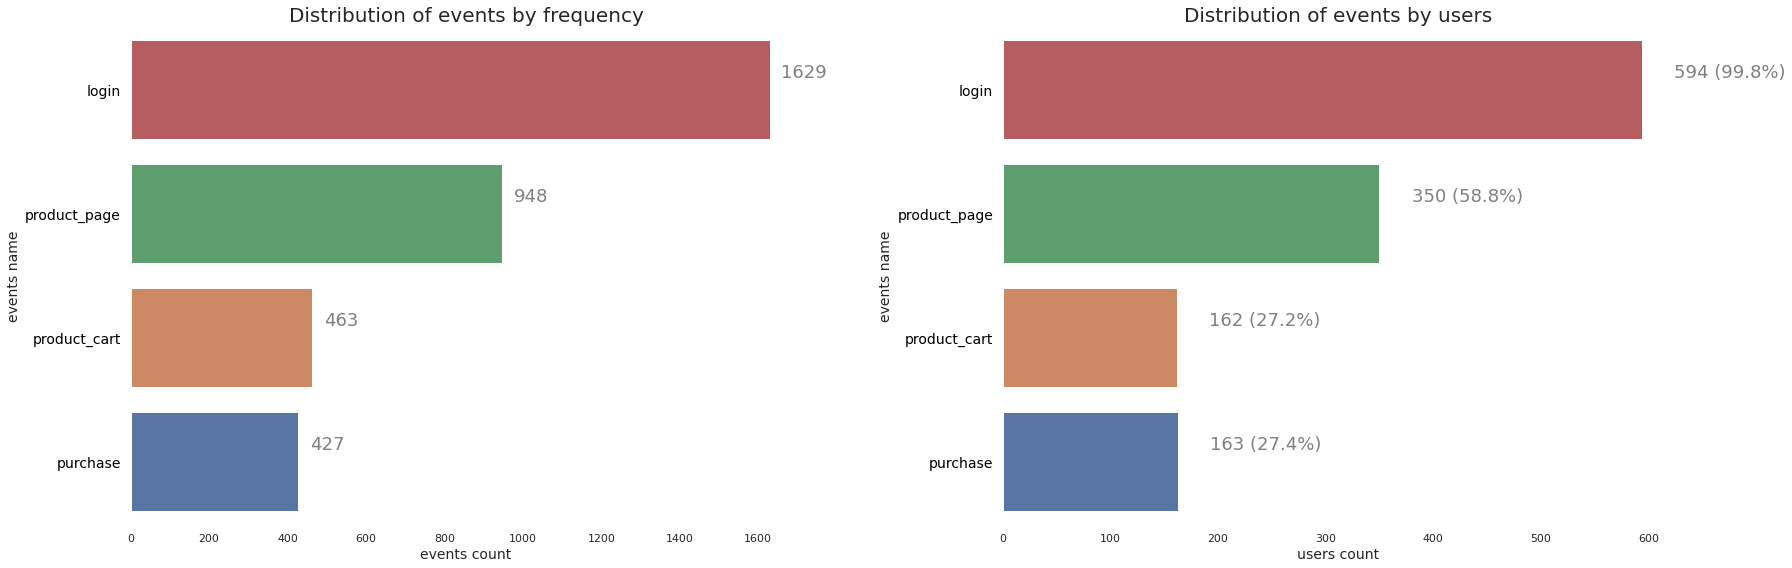

In [46]:
def remove_border(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

def plot_attr(ax,title,xlabel,ylabel):
    ax.title.set_text(title)
    ax.title.set_fontsize(20)
    ax.set_xlabel(xlabel,fontsize=14)
    ax.set_ylabel(ylabel,fontsize=14)

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(25, 8))
order = groupped_events.sort_values('events_cnt').reset_index(drop=True)['event']
sns.barplot(ax=axes[0], y='event', x='events_cnt', order = order,  data=groupped_events)
axes[0].set_yticklabels(order, fontsize=14,color='black')
axes[0].invert_yaxis()
xlabel='events count'
ylabel='events name'
title='Distribution of events by frequency'
plot_attr(axes[0],title,xlabel,ylabel)
for i in axes[0].patches:
    if i.get_width() > 20000:
        axes[0].text(i.get_width()-15000, i.get_y()+0.5, 
                str(int(i.get_width())), fontsize=18, color='white')
    else:
        axes[0].text(i.get_width()+30, i.get_y()+0.5, 
                str(int(i.get_width())), fontsize=18, color='grey')
remove_border(axes[0])

sns.barplot(ax=axes[1],y='event', x='users_cnt', order = order,  data=groupped_events)
axes[1].set_yticklabels(order, fontsize=14,color='black')
axes[1].set_ylabel(None)
axes[1].invert_yaxis()
xlabel='users count'
title='Distribution of events by users'
plot_attr(axes[1],title,xlabel,ylabel)
for i in axes[1].patches:
    if i.get_width() > 5000:
        axes[1].text(i.get_width()-2000, i.get_y()+0.5, 
                str(int(i.get_width()))+' ({:.1%})'.format(i.get_width() / events_val['user_id'].nunique()), fontsize=18, color='white')
    else:
        axes[1].text(i.get_width()+30, i.get_y()+0.5, 
                str(int(i.get_width()))+' ({:.1%})'.format(i.get_width() / events_val['user_id'].nunique()), fontsize=18, color='grey')
remove_border(axes[1])
fig.tight_layout()
fig.subplots_adjust(wspace=0.3)
plt.show()

Логичным порядком событий, регистрирующих отдельные этапы законченного алгоритма поведения пользователя, является:
1. Вход зарегистрированного пользователя (Login);
2. Просмотр карточки товара (Product_page);
3. Просмотр корзины (Product_cart);
4. Покупка (Purchase).



---

Построим воронку событий рассчитав, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем).

In [47]:
def funnel(steps,steps_val,ylabel,title_text):
    '''
    Функция построения воронки событий
    Принимает на вход информацию о событиях (наименование и численность пользователей),
    название графика и подписи осей
    Возвращает и отрисовывает графический объект библиотеки plotly
    '''
    fig = go.Figure(
        go.Funnel(
            y = steps,
            x = steps_val,
            textinfo = "value+percent previous")
    )
    fig.update_layout(
        yaxis_title=ylabel,
        title={
        'text': title_text,
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
        font={
            'size':18
        }    
    )
    fig.show()

In [48]:
steps = groupped_events.sort_values('events_cnt',ascending=False).reset_index(drop=True)['event']
steps_val = groupped_events.sort_values('users_cnt',ascending=False).reset_index(drop=True)['users_cnt']
ylabel="event"
title_text="Funnel of events by users"
funnel(steps,steps_val,ylabel,title_text)

Платежная воронка на первых двух этапах примерно сбалансирована: потери пользователей 41-53%. Практически полное совпадение числа пользователей перешедших в корзину и совершивших покупку, скорее всего, свидетельствует о наличии альтернативной ветки совершения покупки: от карточки товара сразу к завершению процедуры покупки.

### **Исследование информации по событиям и пользователям**

В среднем на одного пользователя из лога приходится 5.8 события, половина пользователей генерирует не более 6 событий.

In [49]:
events_test.groupby('user_id')['event_name'].count().describe().apply(lambda x: format(x, '.1f'))

count    595.0
mean       5.8
std        3.6
min        1.0
25%        3.0
50%        6.0
75%        8.0
max       24.0
Name: event_name, dtype: object

Проверим как распределены события в группах теста.

In [50]:
events_by_group=events_test.pivot_table(index='group',aggfunc={'event_name':'nunique','event_name':'count','user_id':'nunique'}).reset_index()
events_by_group=events_by_group.rename({'event_name':'event_count',	'user_id':'user_count'},axis=1)
events_by_group['events_per_user']=round(events_by_group['event_count']/events_by_group['user_count'],2)
events_by_group

,group,event_count,user_count,events_per_user
0,A,2046,344,5.95
1,B,1421,251,5.66


В среднем пользователи из тестовой группы генерировали меньше событий.


---



Создадим датафреймы, содержащие логи событий для каждой группы теста.

In [51]:
events_A=events_test[events_test['group']=='A']
events_B=events_test[events_test['group']=='B']

Построим графически распределение количества событий, приходящихся на одного пользователя для тестовой и контрольной групп.

In [52]:
def plot_sev_hists(ncols, column, dfs, titles, xlabel, ylabel, **kwargs):
    '''
    Функция построения гистограмм одноименных признаков для нескольких (2-4) датафреймов
    Принимает на вход количество датафреймов, наименование признака, массив датафреймов,
    массив наименований графиков и подписи осей
    Возвращает и отрисовывает объект matplotlib.axes.Axes
    '''
    fig, ax = plt.subplots(nrows=1, ncols=ncols)
    fig.set_size_inches(ncols*7, 10)
    plt.subplots_adjust(wspace=0.2)
    ylim_min=[]
    ylim_max=[]
    for i in range(ncols):
        if dfs[i][column].nunique()<20:
            bins=dfs[i][column].nunique()
            xticks=dfs[i][column].unique()
            setxticks=True
        else:
            bins='auto'
            setxticks=False
            ax[i].axvline(dfs[i][column].mean(), color='red')
        ax[i].hist(dfs[i][column],bins=bins)
        if setxticks:
            ax[i].set_xticks(xticks)
        ax[i].title.set_text(titles[i])
        ax[i].title.set_fontsize(18)
        ax[i].set_xlabel(xlabel)
        ax[i].set_ylabel(ylabel)
        ylim_min.append(ax[i].get_ylim()[0])
        ylim_max.append(ax[i].get_ylim()[1])
    miny = min(ylim_min)
    maxy = max(ylim_max)
    for i in range(ncols):
        ax[i].set_ylim([miny, maxy])
    plt.tight_layout()
    plt.show()

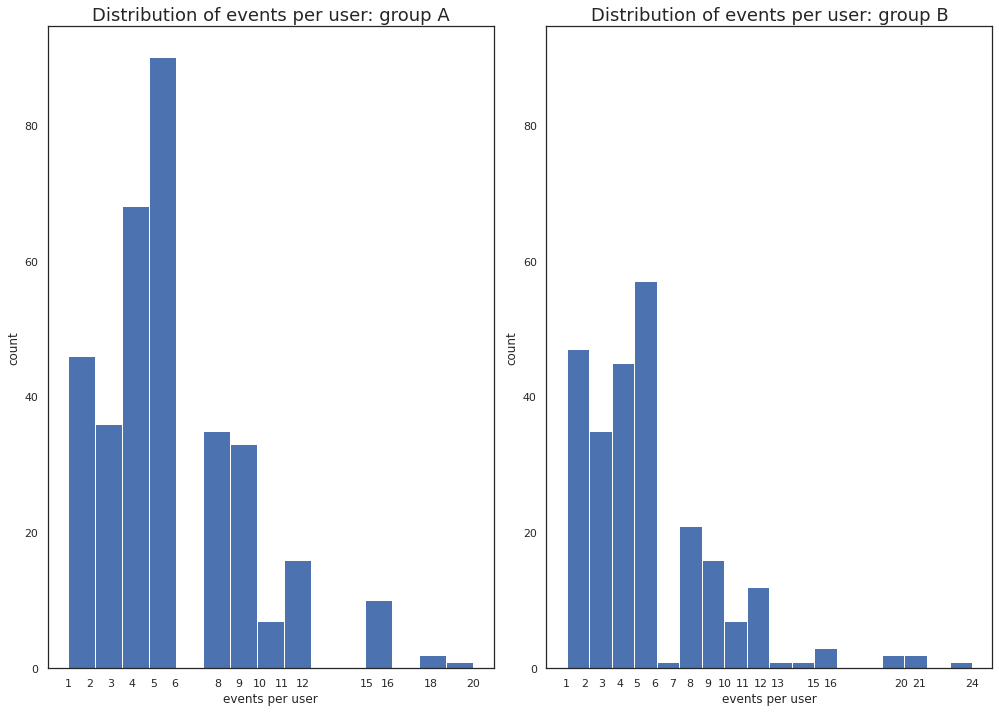

In [53]:
ncols=2
column='event_name'
dfs=[pd.DataFrame(events_A.groupby('user_id')['event_name'].agg('count')),pd.DataFrame(events_B.groupby('user_id')['event_name'].agg('count'))]
titles=['Distribution of events per user: group A','Distribution of events per user: group B']
xlabel='events per user'
ylabel='count'
plot_sev_hists(ncols, column, dfs, titles, xlabel, ylabel)

Распределения совпадают по форме, хотя и имеют несимметричные пропуски и соотношения частот по значениям. Можно заключить, что поведение пользователей двух групп не совпадает.



---


Проанализируем распределение количества сгенерированных событий по дням фиксации.

In [54]:
df1=events_A.copy()
df1['day']=df1['event_dt'].dt.day
df2=events_B.copy()
df2['day']=df2['event_dt'].dt.day

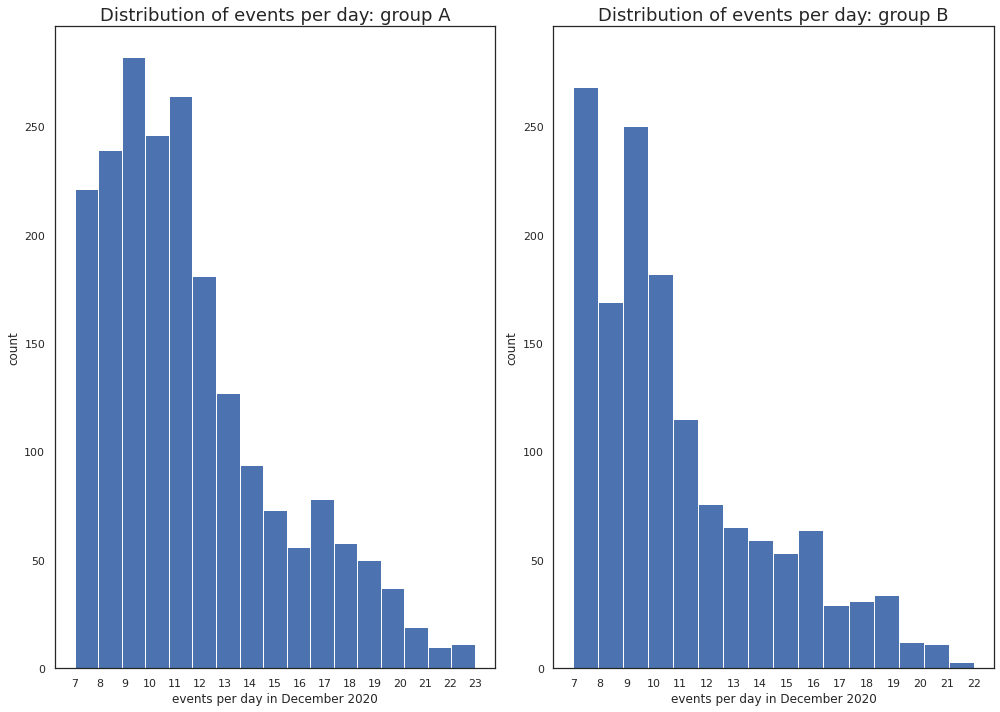

In [55]:
ncols=2
column='day'
dfs=[df1,df2]
titles=['Distribution of events per day: group A','Distribution of events per day: group B']
xlabel='events per day in December 2020'
ylabel='count'
plot_sev_hists(ncols, column, dfs, titles, xlabel, ylabel)

Наблюдается аналогичная картина: распределения походжи по форме, но не тождественны по отдельным значениям.

**Выводы:** в выборках логов событий для тестовой и контрольной групп количество событий на пользователя распределено не одинаково, также отличатся частота генерации событий во времени. Все это свидетельствует о неоднородности  выборок и рисках при использовании усредненных значений при сравнении групп теста.



---

## **Определение эффекта теста**<a  class="anchor" id="effect"></a>

Сгруппируем данные по событиям и группам с расчетом количества пользователей.

In [56]:
events_gr=events_val.pivot_table(index='event_name', columns='group', values='user_id', aggfunc='nunique')
events_gr.rename_axis(" ", axis='index', inplace=True)

In [57]:
events_gr.sort_values('A',ascending=False)

group,A,B
,,
login,344,250
product_page,208,142
product_cart,95,67
purchase,90,73


Определим явно порядок событий в воронке и сохраним в переменной.

In [58]:
ordered_steps=['login','product_page','product_cart','purchase']

Отобразим на графике число и долю пользователей от общей численности группы (конверсию) на каждом шаге воронки.

In [59]:
events_gr_2 = events_test.groupby(['event_name','group'])['user_id'].agg('nunique').reset_index()

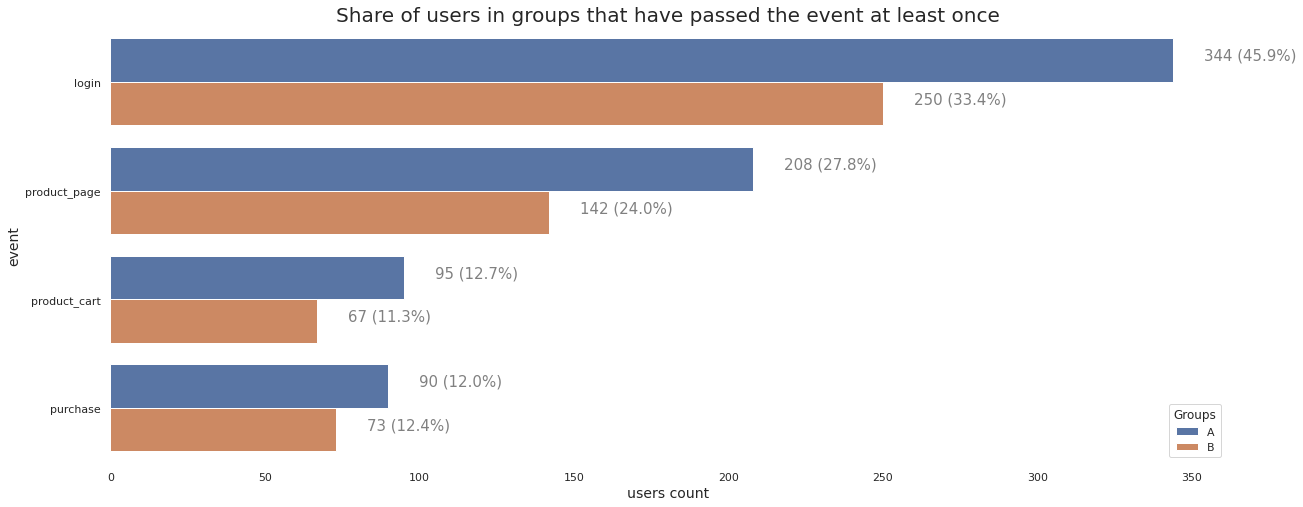

In [60]:
plt.figure(figsize=(20, 8))
ax = sns.barplot(y='event_name', x='user_id', order = ordered_steps, hue='group', data=events_gr_2)
for i,v in enumerate(ax.patches):
    if i < 5:
        if v.get_width() > 1000:
            ax.text(v.get_width()-310, v.get_y()+0.2, 
                str(int(v.get_width()))+' ({:.1%})'.format(v.get_width() / usersA.shape[0]),
                    fontsize=15, color='white')
        else:
            ax.text(v.get_width()+10, v.get_y()+0.2, 
                str(int(v.get_width()))+' ({:.1%})'.format(v.get_width() / usersA.shape[0]),
                    fontsize=15, color='grey')
    if 5 <= i < 10:
        if v.get_width() > 1000:
            ax.text(v.get_width()-310, v.get_y()+0.2, 
                str(int(v.get_width()))+' ({:.1%})'.format(v.get_width() / usersB.shape[0]),
                    fontsize=15, color='white')
        else:
            ax.text(v.get_width()+10, v.get_y()+0.2, 
                str(int(v.get_width()))+' ({:.1%})'.format(v.get_width() / usersB.shape[0]),
                    fontsize=15, color='grey')

title='Share of users in groups that have passed the event at least once'
xlabel='users count'
ylabel='event'
plot_attr(ax,title,xlabel,ylabel)
remove_border(ax)
ax.legend(title="Groups",loc='lower right')
plt.show()

**Выводы:** ожидаемый эффект, который предполагался как улучшение не менее, чем на 10% каждой метрики за 14 дней с момента регистрации пользователей, не достигнут: 

- конверсия в просмотр карточек и просмотры корзины в тестовой группе снизились;
- конверсия в покупки в тестовой группе возрасла менее прогнозируемого значения.



---

## **Оценка результатов теста**<a  class="anchor" id="statistics"></a>

Проверим с помощью пропорционального z-теста, будет ли отличие между группами статистически достоверным.

In [61]:
def perform_ztest(group_A,group_B,group_A_users,group_B_users,steps,alpha=0.05):
    plt.figure(figsize=(25,8))
    plt.suptitle('Share of users having events in group A and group B', y=1.05, fontsize=22,color='red')
    
    def set_titles(ax,title):
        ax.set_title(title)
        ax.title.set_color('black')
        ax.title.set_size(20)
        ax.set_ylabel('share of users')
        ax.set_xlabel('groups')
        ax.set_ylim(0,1)
    
    def plt_text(ax,text,passed):
        if passed=='yes':
            color='green'
        else:
            color='tab:red'
        ax.text(0.5,0.5,text,fontsize='x-large',horizontalalignment='center',verticalalignment='center',linespacing=2,c=color) 
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('off')

    total_A=group_A_users.nunique()
    total_B=group_B_users.nunique()
    p_vals=[]
    metricks_changing=[]

    for i in range(len(steps)):
        pozitive_A=group_A[group_A['event_name']==steps[i]]['user_id'].nunique()
        pozitive_B=group_B[group_B['event_name']==steps[i]]['user_id'].nunique()
        share_A=pozitive_A/total_A
        share_B=pozitive_B/total_B
        metricks_changing.append(format((share_B-share_A)/share_A,'.1%'))

        ax=plt.subplot2grid((4, 4), (0, i),rowspan=3)
        sns.barplot(ax=ax, x=['group A','group  B'], y=[share_A,share_B])
        set_titles(ax,'event: '+steps[i])
        for ind, v in enumerate([share_A,share_B]):
            if isinstance(v, float): v=round(v,3)
            ax.text(ind-0.1,v*0.5, str(v), fontsize=20,color='white')
        
        p_vals.append(proportions_ztest([pozitive_A,pozitive_B],[total_A,total_B])[1])
    
    for i in range(len(steps)):
        if p_vals[i]<=alpha:
            verdict='H0 rejected'
            passed='no'
        else:
            verdict='H0 not rejected'
            passed='yes'
        
        text="relative metrick's changing: "+metricks_changing[i]+'\n'+'proportions ztest \n p-value = '+str(round(p_vals[i],5))+'\n'+verdict
        plt_text(plt.subplot2grid((4, 4), (3, i)),text,passed)
   
    plt.tight_layout()
    plt.show() 

Сформулируем нулевую гипотезу: конверсии регистрации новых пользователей в события для тестовой и контрольной групп не отличаются.

Альтернативная гипотеза: в результате внедрения улучшенной рекомендательной системы конверсии регистрации новых пользователей в события для тестовой и контрольной групп различны.

Уровень значимости alpha примем равным 0,05.

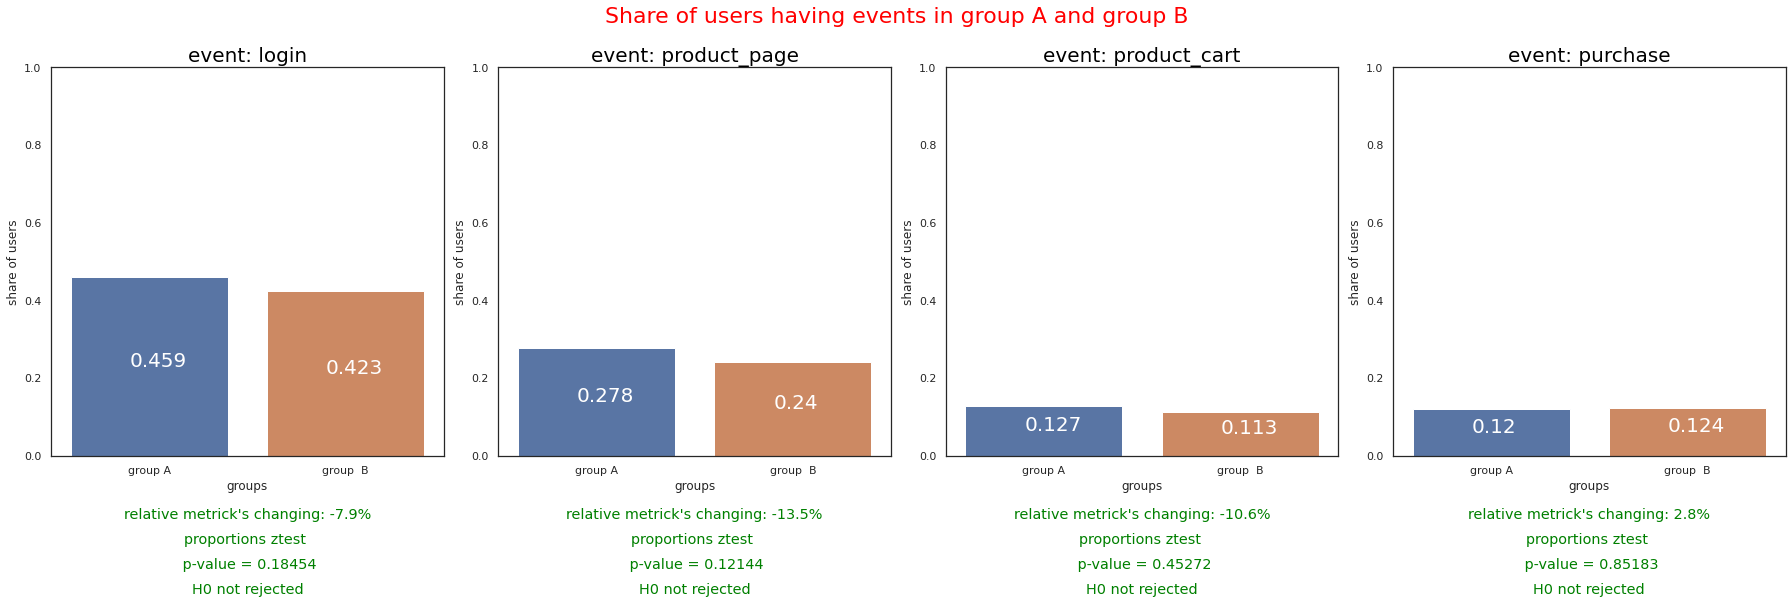

In [62]:
perform_ztest(events_A,events_B,usersA,usersB,ordered_steps)

**Выводы:** в результате проверки статистической разницы долей пользователей, совершивших то или иное событие, от общего количества зарегистрировавшихся z-критерием ни одна нулевая гипотеза не отвергнута.
На представленных данных нельзя утверждать, что в результате внедрения улучшенной рекомендательной системы целевые конверсии для вновь зарегистрировавшихся пользователей изменились.

##  **Выводы и рекомендации**<a  class="anchor" id="summary"></a>

На проведение А/В теста по выявлению влияния внедрения улучшенной рекомендательной системы на метрики конверсии повлияли наложение сроков запуска маркетинговой кампании (новогодняя промокампания, пересечение сроков 34,5%) и параллельно проводимый тест изменений в интерфейсе.

Это привело к сокращению аудитории теста до 22% от запланированной численности.

Для проведения А/В теста использованы данные о поведении двух групп пользователей (контрольная и экспериментальная) в виде логов событий за период с 07.12.2020 по 24.12.2020. 

Общее количество пользователей в двух группах - 1340 человек.

Соотношение численности групп составило 55%:45%.

Группы эксперимента не однороды по поведению пользователей, медианное количество на одного пользователя составило 6 событий для контрольной группы и 4 для тестовой.

Целевые метрики по контрольной группе составили от 12 до 27,8%. 

Для получения статистически значимых заключений об относительном изменении (улучшении) каждой из целевых метрик на 10% (при мощности теста в 80% и пороговом уровне значимсти в 5%) численность групп теста не достаточна.

https://www.evanmiller.org/ab-testing/sample-size.html#!12;80;5;10;1

*Если в техническом задании указан ожидаемый абсолютный эффект на метрики в 10%, численность групп теста стоит признать адекватной*

Расчетный достигнутый эффект в результате внедрения улучшенной рекомендательной системы на метрики оказался по ниже запланированного по конверсии в покупки и противоположным по конверсии в просморт карточек товаров и корзины.

Проведенный пропорциональный z-тест не подтвердил статистическую достоверность отличий в метриках для контрольной и тестовой групп.

Тест стоит признать неудачным.

Рекомендовано подготовить проведение нового теста внедрения улучшенной рекомендательной системы с учетом следующих условий:
- отсутствие одновременно проводимых маркетинговых мероприятий и тестов;
- определения размеров групп теста с учетом достигнутых уровней целевых метрик и ожидаемого эффекта от тестируемых изменений. 